### late-stage diversification, sp3 acid druglike with sp3 amine

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm
import SM_amats

from molprops_utils import myrules, getSSSR

In [2]:
def apply_amat(acid,acid_match,amine,amine_match,rmat):
    """
    needs the smarts of the acid and amine pre-defined. maybe an external dictionary.
    """
    # combine molecules and make a writable version
    both = Chem.CombineMols(acid,amine)
    bothW = Chem.RWMol(both)
    Chem.Kekulize(both,clearAromaticFlags=True)
    Chem.Kekulize(bothW,clearAromaticFlags=True)
    
    # get the indices for the acid and amine matches. 
    amine_atoms = both.GetSubstructMatch(group_dict[amine_match])
    acid_atoms = both.GetSubstructMatch(group_dict[acid_match])
    
    if not (amine_atoms and acid_atoms):
        print("substruct match not found")
        return
    # join the indices
    atom_list = amine_atoms + acid_atoms
#     print(atom_list)
    
    # go through the amat to find places where the change is not 0
    side_len = len(rmat)
    
    if side_len != len(atom_list):
        print("matrix length does not equal number of matched atoms")
        return
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order_change = rmat[r][c]
            if bond_order_change != 0: 
                atom1 = atom_list[amat2ind[r]]
                atom2 = atom_list[amat2ind[c]]
                
                # get the current bond order
                current_bond = both.GetBondBetweenAtoms(atom1,atom2)
                if current_bond: 
                    current_bond_order = current_bond.GetBondTypeAsDouble()                
                else: 
                    current_bond_order = 0
                    
                new_bond_order = current_bond_order + bond_order_change
                
                if new_bond_order not in [0,1,2,3]:
                    print("invalid new bond order")
                    return None
                # make bond changes
                
                bothW.RemoveBond(atom1,atom2)
                
                if new_bond_order > 0:
                    bothW.AddBond(atom1,atom2, bond_dict[new_bond_order])

    try:
        Chem.SanitizeMol(bothW)

    except:
#         print("illegal structure")
        return None

    # may need to become smiles if we want to multitarget, as well as have fragments included.
    return bothW


### we tag the alpha and beta carbons as isotopes, for more precise matching

In [3]:
sp3_acid_smiles = "O=C1N(C2=CC=C([16C@H]([17C]([18O])=[17O])[15C]C)C=C2)CC3=C(F)C=CC=C31"

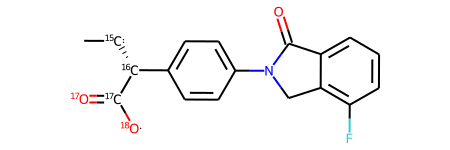

In [4]:
# sp3_acid_smiles = '[17O]=[17C]([18O])[16C]([15C]c1cnc[nH]1)N1C(=O)c2ccccc2C1=O'
couple_acid = Chem.MolFromSmiles(sp3_acid_smiles)
couple_acid

In [5]:
sp3_amine_smiles = "[15N][14C@H]([13C])C1=C(F)C=CC=C1"

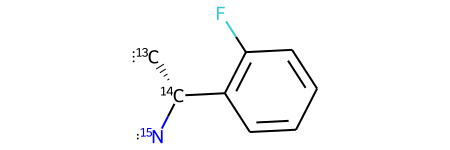

In [6]:
# sp3_amine_smiles = "[15N][14C][13C]C1CCC(N)C1"
couple_amine = Chem.MolFromSmiles(sp3_amine_smiles)
couple_amine

In [7]:
am2 = Chem.MolFromSmarts("[CX3]=[CX3][NH2]")
ac2 = Chem.MolFromSmarts("[CX3][CX3][CX3](=O)[OX2H1]")
am3 = Chem.MolFromSmarts("[13C][14C][15N]")
ac3 = Chem.MolFromSmarts("[15C][16C][17C](=[17O])[18O]")


group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}

# make a mapping dictionary.
# the dictionary is basically, first entry is amine C1. second entry is amine C2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
mapping_order = [0,1,3,4,5,2,6,7]
# mapping_order = [3,4,5,0,1,2,6,7]

# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, mapping_order)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}

### check that the substruct matching hits the right region

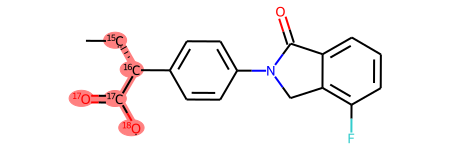

In [8]:
couple_acid.GetSubstructMatch(ac3)
couple_acid

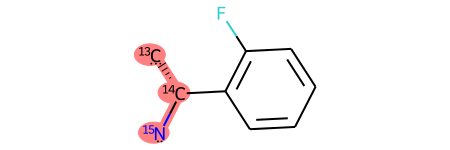

In [9]:
couple_amine.GetSubstructMatch(am3)
couple_amine

### the product matrices and product distances need to be computed before the code below is run.

In [10]:
if not os.path.exists("./ac3drug_am3small/"):
    os.makedirs("./ac3drug_am3small/")

In [11]:
def run_enumeration(file_tag):
    index_start = file_tag * 1000000
    file_tag_str = str(file_tag).zfill(2)

    dmats = np.load(f"../rxn_mats/dmats_ac3_am3_{file_tag_str}.npy")
    amats_valid = pd.read_csv(f"../data_files/smiles_min_dist_6/smiles_md6_{file_tag_str}.csv",index_col=0)
    
    amats_valid = amats_valid[amats_valid.ac3_am3 <= 6].copy()
    amats_valid.reset_index(drop=True,inplace=True)
    
    out_file = open(f"./ac3drug_am3small/matrix_coupling_{file_tag_str}.csv","w")
    
    out_file.write("rmat_tag,pdt_smiles\n")
    
    for i in amats_valid.local_index:
        
        try:
            matrix_index = index_start + i
            m = apply_amat(couple_acid,"ac3",couple_amine,"am3",dmats[i])
            s = Chem.MolToSmiles(m,isomericSmiles=True)
            out_file.write(f"{index_start+i},{s}\n")
        except:
#             print(i)
            continue
    out_file.close()
    

### run the coupling script

In [12]:
# 2 minutes on a single core
for i in tqdm(range(56)):
    run_enumeration(i)

  0%|          | 0/56 [00:00<?, ?it/s]

### for processing - we only want products that have at least one atom from the acid, and amine portions

In [13]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

def check_smiles(s):
    coupled_smiles = []
    split_smiles = s.split(".")
    
    for ss in split_smiles:
        if ss.count("F") == 2:
            if any([i in ss for i in acid_parts]) and any([i in ss for i in amine_parts]):
                coupled_smiles.append(ss)
                
    if len(coupled_smiles) == 0:
        return "C"
    
    else:
        atom_counts = [count_atoms(s) for s in coupled_smiles]
        largest_frag_ind = np.argmax(atom_counts)
        return coupled_smiles[largest_frag_ind]
            
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab])            

In [14]:
all_coupling_data = []
for file_tag in tqdm(range(56)):
    
    file_tag_str = str(file_tag).zfill(2)
    
    distance_data = pd.read_csv(f"../data_files/smiles_min_dist_6/smiles_md6_{file_tag_str}.csv")
    coupling_data = pd.read_csv(f"./ac3drug_am3small/matrix_coupling_{file_tag_str}.csv")

    raw_tags = list(coupling_data.rmat_tag - file_tag*1000000)
    coupling_dists = list(distance_data[distance_data.local_index.isin(raw_tags)].ac3_am3)

    coupling_data["distance"] = coupling_dists


    largest_frag = []
    for s in coupling_data.pdt_smiles:
        largest_frag.append(check_smiles(s))
    coupling_data["largest_frag"] = largest_frag
    
    # remove duplicates
    coupling_data.sort_values("distance",inplace=True)
    coupling_data.drop_duplicates(subset="largest_frag",inplace=True)
    coupling_data.sort_values("rmat_tag",inplace=True)


    all_coupling_data.append(coupling_data)

  0%|          | 0/56 [00:00<?, ?it/s]

### clean up

In [15]:
all_coupling_df = pd.concat(all_coupling_data)
all_coupling_df.sort_values("distance",inplace=True)

all_coupling_df.drop_duplicates(subset="largest_frag",inplace=True)
all_coupling_df.sort_values("rmat_tag",inplace=True)

all_coupling_df = all_coupling_df[all_coupling_df.largest_frag!="C"].copy()

In [16]:
all_coupling_df

,rmat_tag,pdt_smiles,distance,largest_frag
599,41194,C[15C].[13C].[15N][17O][17C]([16CH]c1ccc(N2Cc3...,6.0,[15N][17O][17C]([16CH]c1ccc(N2Cc3c(F)cccc3C2=O...
603,41213,C[15C].[13C].[15N][17C]([17O])([16CH]c1ccc(N2C...,6.0,[15N][17C]([17O])([16CH]c1ccc(N2Cc3c(F)cccc3C2...
607,41316,C[15C].[13C].[15N][16C@H](c1ccc(N2Cc3c(F)cccc3...,6.0,[15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17C...
609,41320,C[15C].[13C].[15N][16C@H](c1ccc(N2Cc3c(F)cccc3...,5.0,[15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17C...
618,42829,C[15C][15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc...,6.0,C[15C][15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc...
...,...,...,...,...
150,54975474,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@@H]([17C]=[...,5.0,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@@H]([17C]=[...
152,54975477,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@H](c1ccc(N2...,4.0,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@H](c1ccc(N2...
153,54975478,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@H](c1ccc(N2...,5.0,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@H](c1ccc(N2...
154,54975507,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@H](c1ccc(N2...,6.0,C[15C](=[13C]=[14CH]c1ccccc1F)[16C@H](c1ccc(N2...


### ring strain filter

In [17]:
def check_bredt(s):
    m = Chem.MolFromSmiles(s)

    if not any([m.HasSubstructMatch(patt) for patt in myrules]):
        return True
    else:
        return False

In [18]:
bredt_check = []
for frg in tqdm(all_coupling_df.largest_frag):
    bredt_check.append(check_bredt(frg))

  0%|          | 0/21242 [00:00<?, ?it/s]

In [19]:
all_coupling_df["bredt"] = bredt_check

In [20]:
all_coupling_df_bredt = all_coupling_df[all_coupling_df.bredt].copy()
all_coupling_df_bredt.reset_index(drop=True,inplace=True)
all_coupling_df_bredt.head()

,rmat_tag,pdt_smiles,distance,largest_frag,bredt
0,41194,C[15C].[13C].[15N][17O][17C]([16CH]c1ccc(N2Cc3...,6.0,[15N][17O][17C]([16CH]c1ccc(N2Cc3c(F)cccc3C2=O...,True
1,41213,C[15C].[13C].[15N][17C]([17O])([16CH]c1ccc(N2C...,6.0,[15N][17C]([17O])([16CH]c1ccc(N2Cc3c(F)cccc3C2...,True
2,41316,C[15C].[13C].[15N][16C@H](c1ccc(N2Cc3c(F)cccc3...,6.0,[15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17C...,True
3,41320,C[15C].[13C].[15N][16C@H](c1ccc(N2Cc3c(F)cccc3...,5.0,[15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17C...,True
4,42829,C[15C][15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc...,6.0,C[15C][15N][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc...,True


### clean up the isotope tags

In [21]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]
tag_part = Chem.MolFromSmarts("[F]")
# replace isotopes with non-isotopes
def clean_structure(s):
    temp = s
    
    for i in acid_parts + amine_parts:
        temp = temp.replace(i,i[-2])
        
    temp_m = Chem.MolFromSmiles(temp)
    temp_out = AllChem.DeleteSubstructs(temp_m,tag_part)
    
    return Chem.MolToSmiles(temp_out,isomericSmiles=True)

# replace isotopic stereocenters with non-isotopic ones
def clean_stereo_C(s):
    temp = s
    iso = ["[16CH]","[16C@H]","[16C@@H]","[14CH]","[14C@H]","[14C@@H]"]
    non_iso = ["C","[C@H]","[C@@H]","C","[C@H]","[C@@H]"]
    for i in range(len(iso)):
        temp = temp.replace(iso[i],non_iso[i])
        
    return temp

In [22]:
s_cleaned = []
for s in tqdm(list(all_coupling_df_bredt['largest_frag'])):
    s_cleaned.append(clean_structure(s))

  0%|          | 0/20997 [00:00<?, ?it/s]

In [23]:
stereo_cleaned = []
for s in s_cleaned:
    stereo_cleaned.append(clean_stereo_C(s))
    
all_coupling_df_bredt["largest_cleaned"] = stereo_cleaned

In [24]:
all_coupling_df_bredt.sort_values("distance",inplace=True)
all_coupling_df_bredt.drop_duplicates(subset="largest_cleaned",inplace=True)
all_coupling_df_bredt.head()

,rmat_tag,pdt_smiles,distance,largest_frag,bredt,largest_cleaned
16650,44332191,C[15C]([13C][14C@@H]([15N])c1ccccc1F)[16C@H](c...,1.0,C[15C]([13C][14C@@H]([15N])c1ccccc1F)[16C@H](c...,True,CC(C[C@@H](N)c1ccccc1)[C@@H](C(=O)O)c1ccc(N2Cc...
8575,34889467,C[15C][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17...,1.0,C[15C][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17...,True,CC[C@@H](C(=O)OC[C@@H](N)c1ccccc1)c1ccc(N2Cc3c...
6894,34093102,C[15C][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17...,1.0,C[15C][16C@H](c1ccc(N2Cc3c(F)cccc3C2=O)cc1)[17...,True,CC[C@@H](C(=O)ON[C@H](C)c1ccccc1)c1ccc(N2Cc3cc...
7151,34095151,C[15C]([15N][14C@H]([13C])c1ccccc1F)[16C@H](c1...,1.0,C[15C]([15N][14C@H]([13C])c1ccccc1F)[16C@H](c1...,True,CC(N[C@H](C)c1ccccc1)[C@@H](C(=O)O)c1ccc(N2Cc3...
7143,34095143,C[15C]([15N][14C@H]([13C])c1ccccc1F)[16C@H](c1...,2.0,C[15C]([15N][14C@H]([13C])c1ccccc1F)[16C@H](c1...,True,CC(N[C@H](C)c1ccccc1)[C@H](c1ccc(N2Cc3ccccc3C2...


### save.

In [25]:
all_coupling_df_bredt[["rmat_tag","distance","largest_frag","largest_cleaned"]].to_csv("./ac3drug_am3small/ac3drug_am3small_smiles.csv",index=False)